# Проект 9 — Самоорганизующиеся карты (Self-Organizing Maps, SOM)

## Теоретическая часть (Theoretical Background)

Самоорганизующиеся карты (Self-Organizing Maps, SOM) — это нейронные сети без учителя, предложенные Тево Кохоненом, для отображения многомерных данных на двумерную решётку.

SOM позволяет визуализировать сложные структуры данных и выявлять кластеры.

### Основные идеи:

1. **Архитектура:**
   - Сеть состоит из нейронов, расположенных в сетке (обычно 2D)
   - Каждый нейрон имеет весовой вектор той же размерности, что и входные данные

2. **Обучение:**
   - На каждом шаге выбирается входной вектор, и определяется нейрон-победитель (Best Matching Unit, BMU)
   - Веса нейрона-победителя и его соседей обновляются
   - Функция соседства уменьшается с расстоянием

3. **Свойства:**
   - Сохраняет топологию данных
   - Уменьшает размерность
   - Обеспечивает визуальное представление кластеров

4. **Типичные применения:**
   - Кластеризация данных
   - Визуализация многомерных признаков
   - Сегментация клиентов, изображений или биологических данных


## Импорт библиотек (Import Libraries)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import kagglehub
import os
import warnings
warnings.filterwarnings('ignore')

# Настройка для отображения графиков
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline


## Задача 1: Подготовка данных (Data Preparation)

Загрузим и подготовим данные Customer Personality Analysis Dataset.


In [2]:
# Download dataset from Kaggle
print("Downloading Customer Personality Analysis dataset from Kaggle...")
try:
    # Download latest version
    path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
    print("Path to dataset files:", path)
    
    # Search for data file in the downloaded directory
    # Usually the file is named marketing_campaign.csv
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    
    if csv_files:
        # Use the first found CSV file
        csv_file = os.path.join(path, csv_files[0])
        print(f"Found file: {csv_file}")
        
        # Try loading with different delimiters
        try:
            df = pd.read_csv(csv_file, sep='\t')
            print("Data loaded with tab delimiter")
        except:
            try:
                df = pd.read_csv(csv_file, sep=',')
                print("Data loaded with comma delimiter")
            except:
                df = pd.read_csv(csv_file)
                print("Data loaded with automatic delimiter detection")
    else:
        # If CSV file is not found, search in subdirectories
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.csv'):
                    csv_file = os.path.join(root, file)
                    print(f"Found file in subdirectory: {csv_file}")
                    try:
                        df = pd.read_csv(csv_file, sep='\t')
                        break
                    except:
                        try:
                            df = pd.read_csv(csv_file, sep=',')
                            break
                        except:
                            df = pd.read_csv(csv_file)
                            break
            else:
                continue
            break
        else:
            raise FileNotFoundError("CSV file not found in the downloaded dataset.")
            
except Exception as e:
    print(f"Error loading from Kaggle: {e}")
    print("Attempting to load from local file...")
    try:
        df = pd.read_csv('marketing_campaign.csv', sep='\t')
        print("Data loaded from local file")
    except FileNotFoundError:
        print("Local file not found. Using synthetic data for demonstration...")
        # Create synthetic data for demonstration
        np.random.seed(42)
        n_samples = 2000
        df = pd.DataFrame({
            'Year_Birth': np.random.randint(1940, 2000, n_samples),
            'Education': np.random.choice(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], n_samples),
            'Marital_Status': np.random.choice(['Single', 'Together', 'Married', 'Divorced', 'Widow'], n_samples),
            'Income': np.random.normal(50000, 20000, n_samples),
            'Kidhome': np.random.choice([0, 1, 2], n_samples),
            'Teenhome': np.random.choice([0, 1, 2], n_samples),
            'Recency': np.random.randint(0, 100, n_samples),
            'MntWines': np.random.poisson(300, n_samples),
            'MntFruits': np.random.poisson(50, n_samples),
            'MntMeatProducts': np.random.poisson(200, n_samples),
            'MntFishProducts': np.random.poisson(50, n_samples),
            'MntSweetProducts': np.random.poisson(50, n_samples),
            'MntGoldProds': np.random.poisson(50, n_samples),
            'NumDealsPurchases': np.random.poisson(2, n_samples),
            'NumWebPurchases': np.random.poisson(5, n_samples),
            'NumCatalogPurchases': np.random.poisson(3, n_samples),
            'NumStorePurchases': np.random.poisson(6, n_samples),
            'NumWebVisitsMonth': np.random.poisson(5, n_samples),
            'AcceptedCmp1': np.random.choice([0, 1], n_samples),
            'AcceptedCmp2': np.random.choice([0, 1], n_samples),
            'AcceptedCmp3': np.random.choice([0, 1], n_samples),
            'AcceptedCmp4': np.random.choice([0, 1], n_samples),
            'AcceptedCmp5': np.random.choice([0, 1], n_samples),
            'Response': np.random.choice([0, 1], n_samples),
            'Complain': np.random.choice([0, 1], n_samples)
        })
        df['Income'] = np.abs(df['Income'])  # Ensure income is positive
        print("Synthetic data created")

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst rows:")
df.head()


Path to dataset files: C:\Users\77noo\.cache\kagglehub\datasets\imakash3011\customer-personality-analysis\versions\1
Found file: C:\Users\77noo\.cache\kagglehub\datasets\imakash3011\customer-personality-analysis\versions\1\marketing_campaign.csv
Data loaded with tab delimiter

Dataset shape: (2240, 29)

First rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
print("Dataset info:")
print(df.info())
print("\nDescriptive statistics:")
df.describe()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    224

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [21]:
# Handle missing values
print("Missing values:")
print(df.isnull().sum().sum())
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print(f"Rows with missing values removed. New size: {df.shape}")

# Select key features for analysis
# Choose numerical features related to customer behavior
feature_columns = [
    'Year_Birth',
    'Income',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth'
]

# Check availability of all columns
available_features = [col for col in feature_columns if col in df.columns]
print(f"\nSelected features: {available_features}")

# Create dataset with selected features
data = df[available_features].copy()

# Calculate age from year of birth
if 'Year_Birth' in data.columns:
    data['Age'] = 2025 - data['Year_Birth']
    data = data.drop('Year_Birth', axis=1)

print(f"\nFinal data size: {data.shape}")
print(f"\nFeatures: {list(data.columns)}")
data.head()


Missing values:
0

Selected features: ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Final data size: (2216, 14)

Features: ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age']


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age
0,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,68
1,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,71
2,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,60
3,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,41
4,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,44


In [5]:
# Data normalization
# Import necessary libraries (in case import cell was not executed)
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

print("Data normalized (StandardScaler)")
print(f"Mean: {data_scaled.mean().mean():.6f}")
print(f"Standard deviation: {data_scaled.std().mean():.6f}")
print("\nFirst rows of normalized data:")
data_scaled.head()


Data normalized (StandardScaler)
Mean: -0.000000
Standard deviation: 1.000226

First rows of normalized data:


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age
0,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232,0.986443
1,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574,1.236801
2,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978,0.318822
3,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,-0.168231,-0.760962,-0.912837,-0.554143,0.280829,-1.266777
4,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,1.391603,0.333796,0.112428,0.061232,-0.131574,-1.016420


## Задача 2: Реализация SOM (SOM Implementation)

Реализуем класс Self-Organizing Map с сеткой нейронов 10×10.


In [6]:
class SelfOrganizingMap:
    """
    Implementation of Kohonen's Self-Organizing Map (SOM)
    """
    
    def __init__(self, grid_size=(10, 10), input_dim=None, learning_rate=0.5, 
                 radius=None, random_seed=42, init_method='random'):
        """
        Parameters:
        - grid_size: grid size (height, width)
        - input_dim: input data dimensionality
        - learning_rate: initial learning rate
        - radius: initial neighborhood radius (if None, computed automatically)
        - random_seed: seed for reproducibility
        - init_method: initialization method ('random' or 'pca')
        """
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        self.init_method = init_method
        
        if radius is None:
            # Initial radius is typically half of the grid size
            self.radius = max(grid_size) / 2
        else:
            self.radius = radius
        
        # Initialize weights (will be set in _initialize_weights)
        self.weights = None
        
        # Create neuron coordinates in the grid
        self.coords = np.array([[i, j] for i in range(grid_size[0]) 
                                for j in range(grid_size[1])])
        self.coords = self.coords.reshape(grid_size[0], grid_size[1], 2)
        
    def _initialize_weights(self, data):
        """Initialize weights using specified method"""
        np.random.seed(self.random_seed)
        
        if self.init_method == 'pca':
            # PCA-based initialization: better starting point
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2, random_state=self.random_seed)
            pca_data = pca.fit_transform(data)
            
            # Normalize PCA components to grid coordinates
            pca_data = (pca_data - pca_data.min(axis=0)) / (pca_data.max(axis=0) - pca_data.min(axis=0))
            pca_data[:, 0] *= (self.grid_size[0] - 1)
            pca_data[:, 1] *= (self.grid_size[1] - 1)
            
            # Initialize weights by interpolating data points
            self.weights = np.random.randn(self.grid_size[0], self.grid_size[1], self.input_dim) * 0.1
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    # Find nearest data points in PCA space
                    distances = np.sqrt((pca_data[:, 0] - i)**2 + (pca_data[:, 1] - j)**2)
                    nearest_idx = np.argmin(distances)
                    self.weights[i, j] = data[nearest_idx] + np.random.randn(self.input_dim) * 0.01
        else:
            # Random initialization
            self.weights = np.random.randn(self.grid_size[0], self.grid_size[1], self.input_dim)
        
    def find_bmu(self, input_vector):
        """
        Find Best Matching Unit (BMU) - winning neuron
        for the given input vector
        """
        # Compute Euclidean distance from input vector to all neurons
        distances = np.sum((self.weights - input_vector) ** 2, axis=2)
        # Find index of minimum distance
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_idx
    
    def neighborhood_function(self, distance, radius):
        """
        Neighborhood function (Gaussian)
        """
        return np.exp(-(distance ** 2) / (2 * (radius ** 2)))
    
    def update_weights(self, input_vector, bmu_idx, learning_rate, radius):
        """
        Update neuron weights based on BMU and neighborhood function
        Optimized with vectorized operations
        """
        # Compute distances from BMU to all neurons in the grid
        bmu_coords = np.array(bmu_idx)
        distances = np.sum((self.coords - bmu_coords) ** 2, axis=2)
        distances = np.sqrt(distances)
        
        # Compute neighborhood function
        neighborhood = self.neighborhood_function(distances, radius)
        
        # Vectorized weight update
        influence = neighborhood[:, :, np.newaxis] * learning_rate
        self.weights += influence * (input_vector - self.weights)
    
    def train(self, data, n_iterations=1000, verbose=True, batch_size=None):
        """
        Train SOM on data
        
        Parameters:
        - data: normalized data (numpy array or pandas DataFrame)
        - n_iterations: number of training iterations
        - verbose: whether to print progress
        - batch_size: if specified, use batch training (None for online training)
        """
        if isinstance(data, pd.DataFrame):
            data = data.values
        
        # Initialize weights if not already initialized
        if self.weights is None:
            self._initialize_weights(data)
        
        n_samples = len(data)
        
        # Parameters for adaptive learning
        initial_lr = self.learning_rate
        initial_radius = self.radius
        
        # Training history for convergence tracking
        self.training_history = []
        
        for iteration in range(n_iterations):
            if batch_size is None:
                # Online training: select random sample
                sample_idx = np.random.randint(0, n_samples)
                sample = data[sample_idx]
                
                # Find BMU
                bmu_idx = self.find_bmu(sample)
                
                # Adaptively decrease learning rate and radius
                current_lr = initial_lr * np.exp(-iteration / n_iterations)
                current_radius = initial_radius * np.exp(-iteration / n_iterations)
                
                # Update weights
                self.update_weights(sample, bmu_idx, current_lr, current_radius)
            else:
                # Batch training: process multiple samples
                batch_indices = np.random.choice(n_samples, batch_size, replace=False)
                batch_samples = data[batch_indices]
                
                current_lr = initial_lr * np.exp(-iteration / n_iterations)
                current_radius = initial_radius * np.exp(-iteration / n_iterations)
                
                for sample in batch_samples:
                    bmu_idx = self.find_bmu(sample)
                    self.update_weights(sample, bmu_idx, current_lr, current_radius)
            
            # Track quantization error for convergence
            if verbose and (iteration + 1) % (n_iterations // 10) == 0:
                qe = self._quantization_error(data)
                self.training_history.append(qe)
                print(f"Iteration {iteration + 1}/{n_iterations} completed - Quantization Error: {qe:.4f}")
    
    def _quantization_error(self, data):
        """Calculate quantization error (average distance to BMU)"""
        if isinstance(data, pd.DataFrame):
            data = data.values
        
        total_error = 0
        for sample in data:
            bmu_idx = self.find_bmu(sample)
            error = np.linalg.norm(sample - self.weights[bmu_idx])
            total_error += error
        
        return total_error / len(data)
    
    def predict(self, data):
        """
        Predict BMU for each data sample
        """
        if isinstance(data, pd.DataFrame):
            data = data.values
        
        predictions = []
        for sample in data:
            bmu_idx = self.find_bmu(sample)
            predictions.append(bmu_idx)
        
        return np.array(predictions)
    
    def get_u_matrix(self):
        """
        Compute U-Matrix (Unified Distance Matrix) for visualization
        U-Matrix shows average distances between neighboring neurons
        """
        u_matrix = np.zeros(self.grid_size)
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neighbors = []
                
                # Check neighbors (up, down, left, right)
                if i > 0:
                    neighbors.append(self.weights[i-1, j])
                if i < self.grid_size[0] - 1:
                    neighbors.append(self.weights[i+1, j])
                if j > 0:
                    neighbors.append(self.weights[i, j-1])
                if j < self.grid_size[1] - 1:
                    neighbors.append(self.weights[i, j+1])
                
                if neighbors:
                    # Compute average distance to neighbors
                    distances = [np.linalg.norm(self.weights[i, j] - neighbor) 
                                for neighbor in neighbors]
                    u_matrix[i, j] = np.mean(distances)
        
        return u_matrix


In [7]:
# Create and train SOM
print("Creating SOM with 10x10 grid...")
som = SelfOrganizingMap(
    grid_size=(10, 10),
    input_dim=data_scaled.shape[1],
    learning_rate=0.5,
    random_seed=42,
    init_method='pca'  # Use PCA initialization for better starting point
)

print("Starting training...")
som.train(data_scaled, n_iterations=1000, verbose=True)
print("Training completed!")


Creating SOM with 10x10 grid...
Starting training...
Iteration 100/1000 completed - Quantization Error: 2.7943
Iteration 200/1000 completed - Quantization Error: 2.8737
Iteration 300/1000 completed - Quantization Error: 2.7396
Iteration 400/1000 completed - Quantization Error: 2.4600
Iteration 500/1000 completed - Quantization Error: 2.6209
Iteration 600/1000 completed - Quantization Error: 2.3927
Iteration 700/1000 completed - Quantization Error: 2.3599
Iteration 800/1000 completed - Quantization Error: 2.2947
Iteration 900/1000 completed - Quantization Error: 2.2412
Iteration 1000/1000 completed - Quantization Error: 2.2076
Training completed!


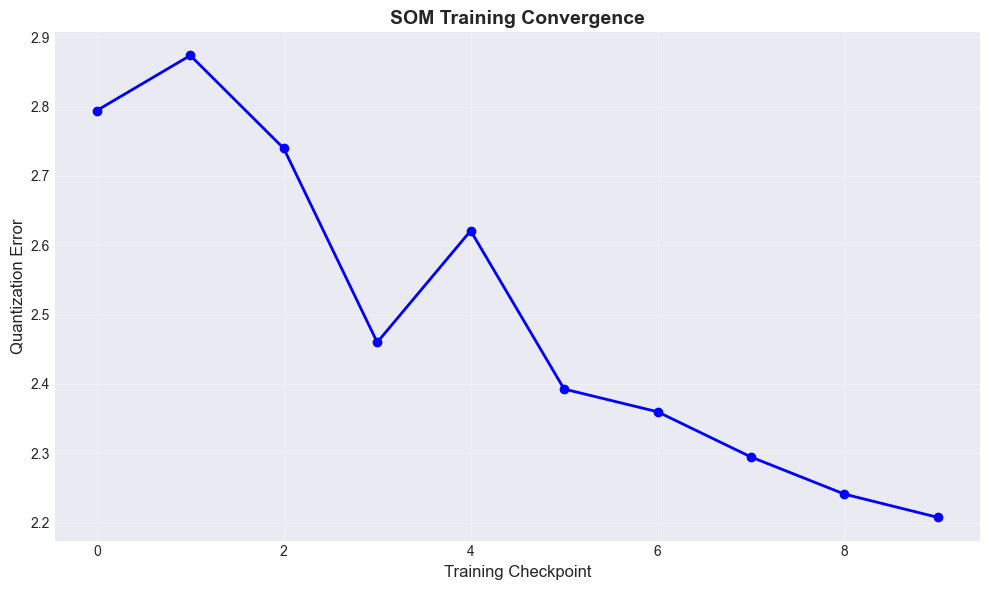

Quantization error shows how well the SOM represents the data.
Lower values indicate better representation.


In [8]:
# Visualize training convergence (quantization error)
if hasattr(som, 'training_history') and len(som.training_history) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(som.training_history)), som.training_history, 'b-o', linewidth=2, markersize=6)
    plt.xlabel('Training Checkpoint', fontsize=12)
    plt.ylabel('Quantization Error', fontsize=12)
    plt.title('SOM Training Convergence', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Quantization error shows how well the SOM represents the data.")
    print("Lower values indicate better representation.")


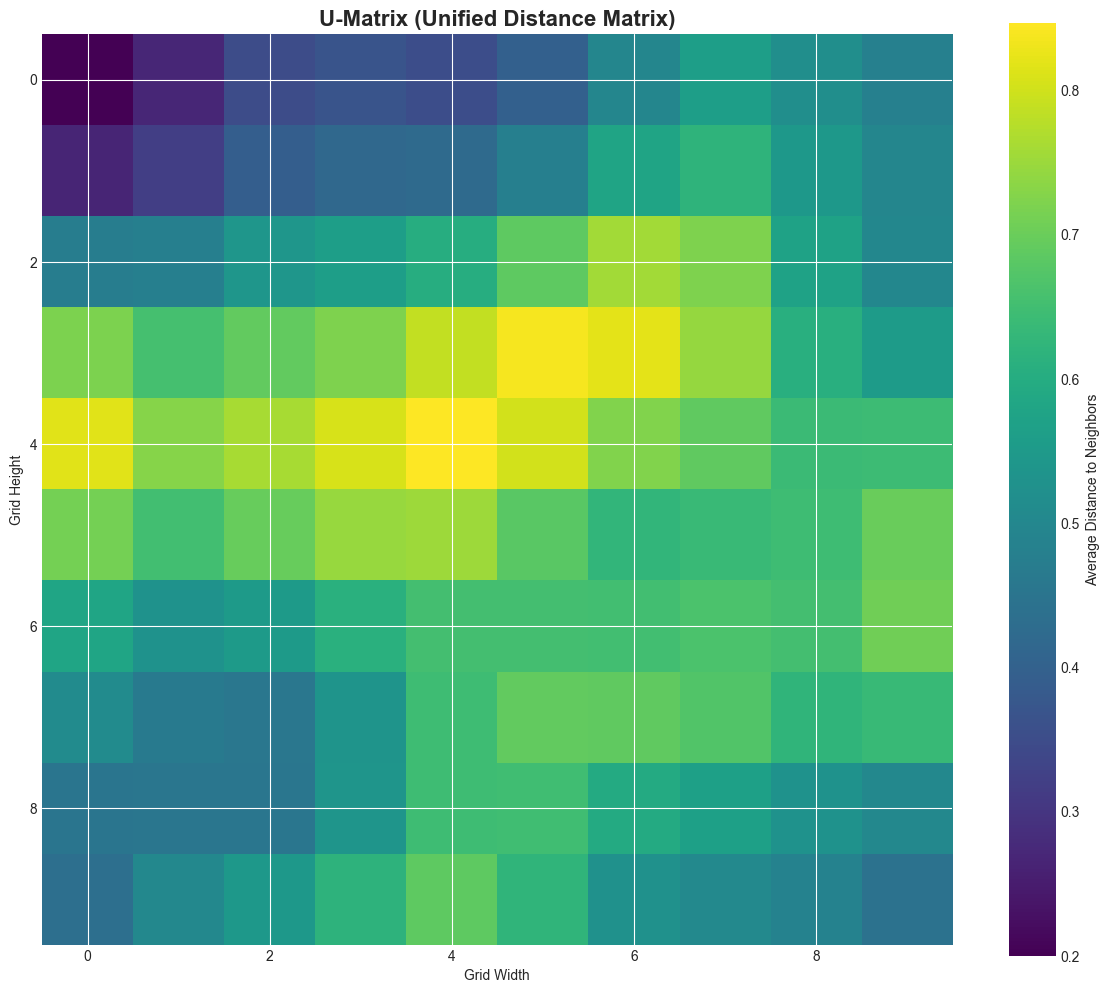

In [9]:
# Compute U-Matrix
u_matrix = som.get_u_matrix()

# Visualize U-Matrix
plt.figure(figsize=(12, 10))
plt.imshow(u_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Average Distance to Neighbors')
plt.title('U-Matrix (Unified Distance Matrix)', fontsize=16, fontweight='bold')
plt.xlabel('Grid Width')
plt.ylabel('Grid Height')
plt.tight_layout()
plt.show()

# Interpretation: dark areas = clusters, light areas = boundaries between clusters


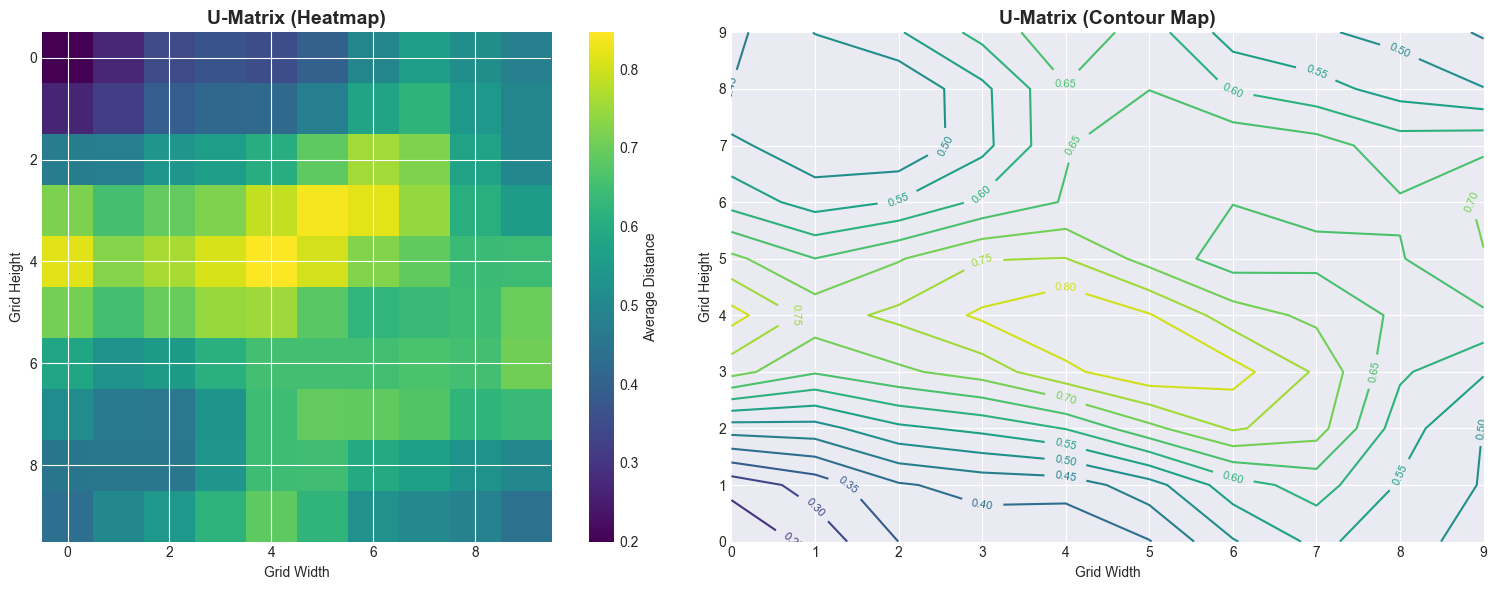

In [10]:
# Alternative U-Matrix visualization with contour lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im1 = ax1.imshow(u_matrix, cmap='viridis', interpolation='nearest')
ax1.set_title('U-Matrix (Heatmap)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Grid Width')
ax1.set_ylabel('Grid Height')
plt.colorbar(im1, ax=ax1, label='Average Distance')

# Contour map
contour = ax2.contour(u_matrix, levels=15, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_title('U-Matrix (Contour Map)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Grid Width')
ax2.set_ylabel('Grid Height')

plt.tight_layout()
plt.show()


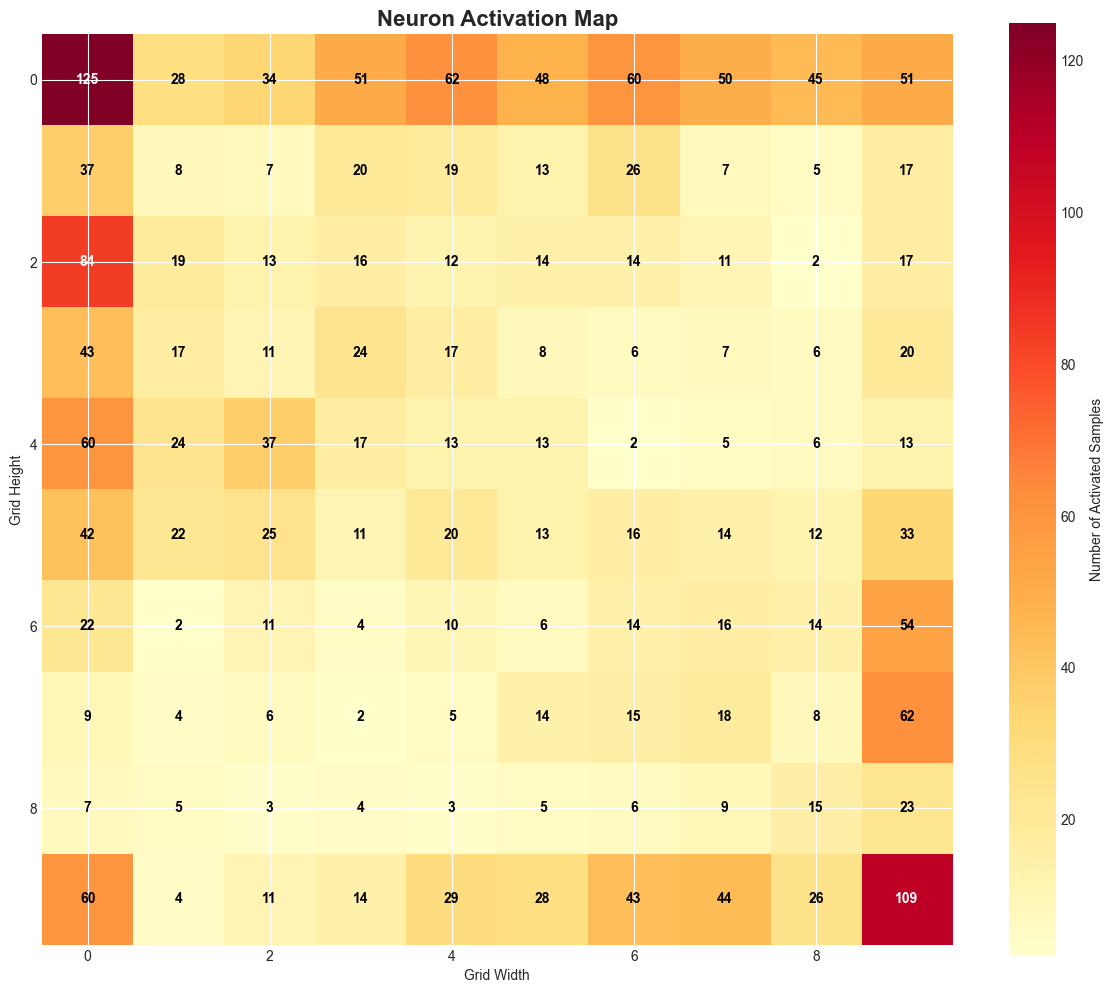

In [11]:
# Visualize data distribution on the map
predictions = som.predict(data_scaled)

# Create neuron activation frequency map
activation_map = np.zeros(som.grid_size)
for pred in predictions:
    activation_map[pred[0], pred[1]] += 1

plt.figure(figsize=(12, 10))
plt.imshow(activation_map, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Number of Activated Samples')
plt.title('Neuron Activation Map', fontsize=16, fontweight='bold')
plt.xlabel('Grid Width')
plt.ylabel('Grid Height')

# Add annotations with counts
for i in range(som.grid_size[0]):
    for j in range(som.grid_size[1]):
        if activation_map[i, j] > 0:
            plt.text(j, i, int(activation_map[i, j]), 
                    ha='center', va='center', 
                    color='white' if activation_map[i, j] > activation_map.max()/2 else 'black',
                    fontweight='bold')

plt.tight_layout()
plt.show()


## Задача 4: Определение кластеров и интерпретация результатов

Определим кластеры клиентов на основе SOM и проанализируем их характеристики.


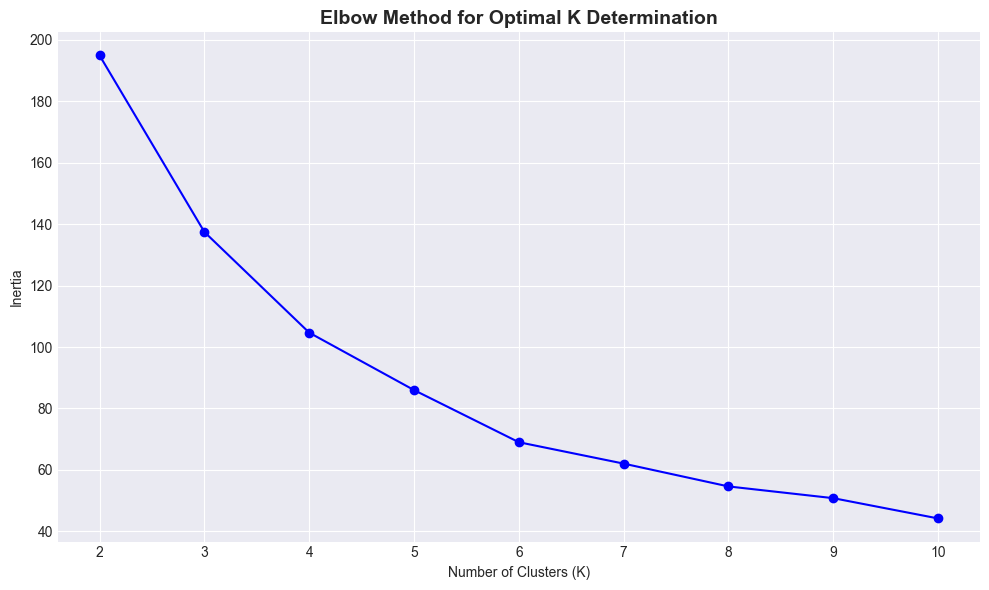

Selected number of clusters: 5


In [12]:
# Use K-Means on SOM weights to determine clusters
# This allows automatic determination of the number of clusters

# Get weights of all neurons
neuron_weights = som.weights.reshape(-1, som.input_dim)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(neuron_weights)
    inertias.append(kmeans_temp.inertia_)

# Visualize elbow method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K Determination', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select optimal K (typically 4-6 for this dataset)
optimal_k = 5
print(f"Selected number of clusters: {optimal_k}")


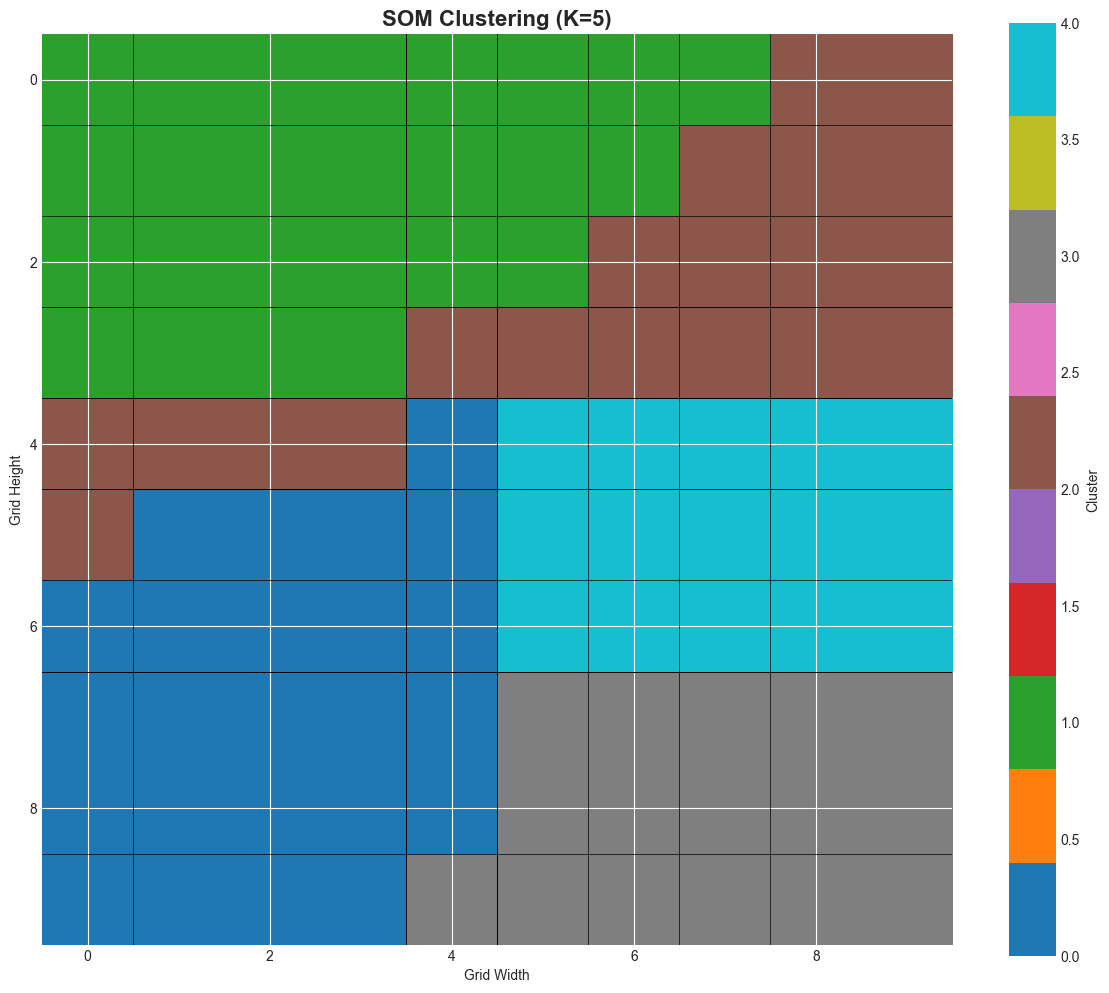

In [13]:
# Apply K-Means to SOM neuron weights
kmeans_som = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
neuron_clusters = kmeans_som.fit_predict(neuron_weights)
neuron_clusters = neuron_clusters.reshape(som.grid_size)

# Visualize clusters on the map
plt.figure(figsize=(12, 10))
plt.imshow(neuron_clusters, cmap='tab10', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title(f'SOM Clustering (K={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel('Grid Width')
plt.ylabel('Grid Height')

# Add cluster boundaries
for i in range(som.grid_size[0]):
    for j in range(som.grid_size[1]):
        # Check neighbors to determine boundaries
        if i < som.grid_size[0] - 1 and neuron_clusters[i, j] != neuron_clusters[i+1, j]:
            plt.axhline(i + 0.5, color='black', linewidth=0.5)
        if j < som.grid_size[1] - 1 and neuron_clusters[i, j] != neuron_clusters[i, j+1]:
            plt.axvline(j + 0.5, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()


In [14]:
# Assign clusters to each data sample
data_predictions = som.predict(data_scaled)
sample_clusters = np.array([neuron_clusters[pred[0], pred[1]] for pred in data_predictions])

# Add cluster information to original data
df_with_clusters = df.copy()
df_with_clusters['SOM_Cluster'] = sample_clusters

print("Sample distribution across clusters:")
print(df_with_clusters['SOM_Cluster'].value_counts().sort_index())
print(f"\nTotal clusters: {len(df_with_clusters['SOM_Cluster'].unique())}")


Sample distribution across clusters:
SOM_Cluster
0    277
1    841
2    413
3    454
4    231
Name: count, dtype: int64

Total clusters: 5


CLUSTER CHARACTERISTICS ANALYSIS

Average feature values by cluster:
             Year_Birth    Income  Recency  MntWines  MntFruits  \
SOM_Cluster                                                       
0               1963.76  59482.43    51.66    562.78      22.99   
1               1973.43  32008.73    52.96     33.66       4.90   
2               1964.46  50137.85    38.69    174.45      10.42   
3               1967.75  74889.90    49.68    567.70      80.91   
4               1967.98  76523.78    48.61    701.74      29.77   

             MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
SOM_Cluster                                                                     
0                     166.03            27.62             24.52         75.95   
1                      21.75             7.43              5.06         16.51   
2                      59.18            14.37             10.21         30.15   
3                     440.93           118.10           

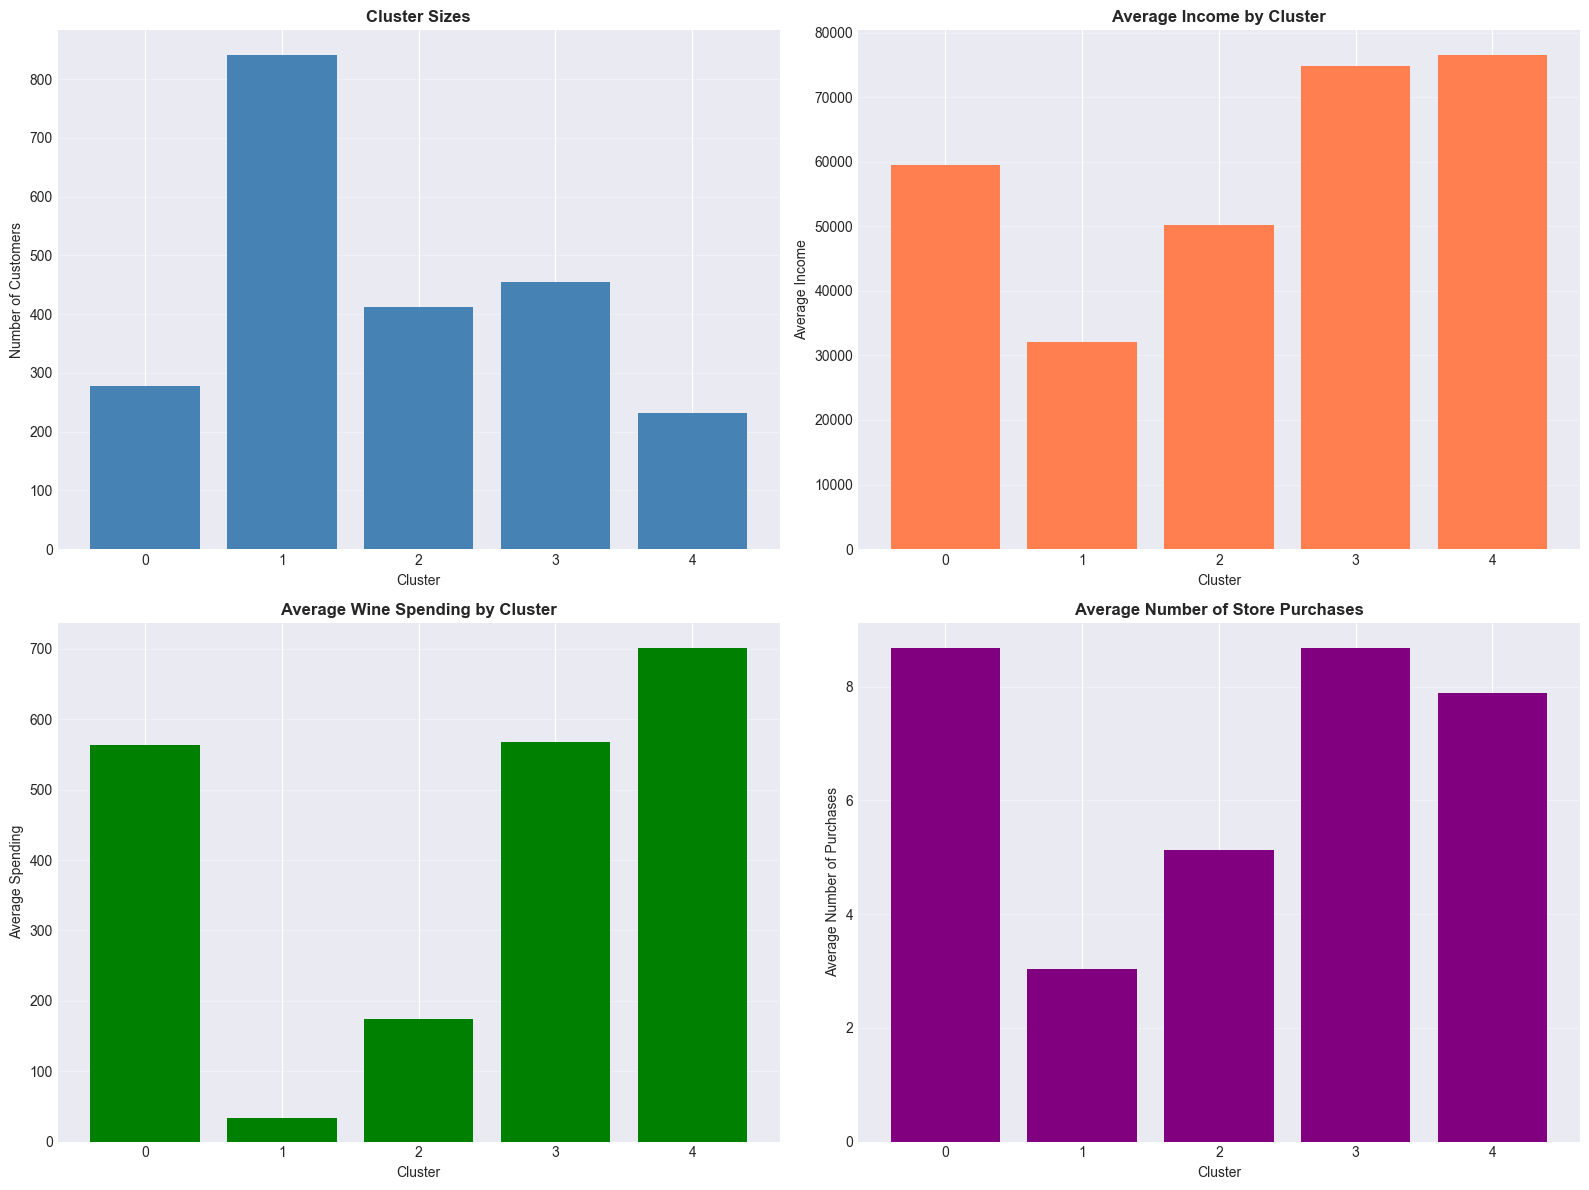

In [15]:
# Cluster characteristics analysis
print("=" * 80)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("=" * 80)

cluster_analysis = df_with_clusters.groupby('SOM_Cluster')[available_features].mean()

# Add cluster size
cluster_sizes = df_with_clusters['SOM_Cluster'].value_counts().sort_index()
cluster_analysis['Cluster_Size'] = cluster_sizes.values

print("\nAverage feature values by cluster:")
print(cluster_analysis.round(2))

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster sizes
axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
axes[0, 0].set_title('Cluster Sizes', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Income by cluster
if 'Income' in available_features:
    income_by_cluster = df_with_clusters.groupby('SOM_Cluster')['Income'].mean()
    axes[0, 1].bar(income_by_cluster.index, income_by_cluster.values, color='coral')
    axes[0, 1].set_title('Average Income by Cluster', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Cluster')
    axes[0, 1].set_ylabel('Average Income')
    axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Wine spending by cluster
if 'MntWines' in available_features:
    wine_by_cluster = df_with_clusters.groupby('SOM_Cluster')['MntWines'].mean()
    axes[1, 0].bar(wine_by_cluster.index, wine_by_cluster.values, color='green')
    axes[1, 0].set_title('Average Wine Spending by Cluster', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Average Spending')
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Store purchases
if 'NumStorePurchases' in available_features:
    store_by_cluster = df_with_clusters.groupby('SOM_Cluster')['NumStorePurchases'].mean()
    axes[1, 1].bar(store_by_cluster.index, store_by_cluster.values, color='purple')
    axes[1, 1].set_title('Average Number of Store Purchases', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Average Number of Purchases')
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


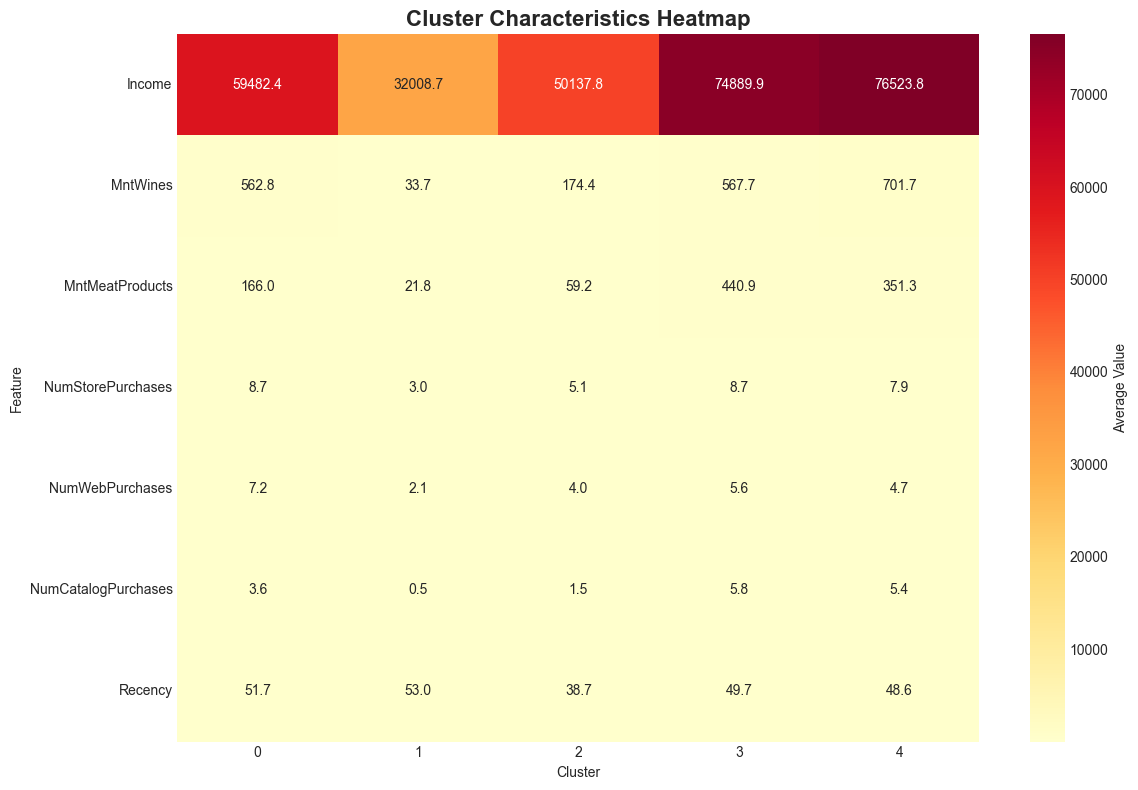

In [16]:
# Cluster characteristics heatmap
if 'Income' in available_features:
    # Select key features for visualization
    key_features = ['Income', 'MntWines', 'MntMeatProducts', 'NumStorePurchases', 
                    'NumWebPurchases', 'NumCatalogPurchases', 'Recency']
    key_features = [f for f in key_features if f in available_features]
    
    cluster_heatmap = df_with_clusters.groupby('SOM_Cluster')[key_features].mean()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_heatmap.T, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Average Value'})
    plt.title('Cluster Characteristics Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Cluster')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [17]:
# Cluster interpretation
print("\n" + "=" * 80)
print("CLUSTER INTERPRETATION")
print("=" * 80)

for cluster_id in sorted(df_with_clusters['SOM_Cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['SOM_Cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_with_clusters)*100:.1f}%)")
    
    if 'Income' in available_features:
        print(f"Average income: ${cluster_data['Income'].mean():.2f}")
    if 'Age' in df_with_clusters.columns:
        print(f"Average age: {cluster_data['Age'].mean():.1f} years")
    if 'MntWines' in available_features:
        print(f"Average wine spending: ${cluster_data['MntWines'].mean():.2f}")
    if 'NumStorePurchases' in available_features:
        print(f"Average number of store purchases: {cluster_data['NumStorePurchases'].mean():.2f}")
    if 'Recency' in available_features:
        print(f"Average recency: {cluster_data['Recency'].mean():.1f} days")
    
    # Determine cluster type
    if 'Income' in available_features and 'MntWines' in available_features:
        avg_income = cluster_data['Income'].mean()
        avg_wine = cluster_data['MntWines'].mean()
        
        if avg_income > df_with_clusters['Income'].quantile(0.75):
            if avg_wine > df_with_clusters['MntWines'].quantile(0.75):
                cluster_type = "Premium customers (high income, high spending)"
            else:
                cluster_type = "Wealthy but frugal"
        elif avg_income < df_with_clusters['Income'].quantile(0.25):
            cluster_type = "Budget customers"
        else:
            cluster_type = "Middle segment"
        
        print(f"Type: {cluster_type}")



CLUSTER INTERPRETATION

--- Cluster 0 ---
Size: 277 customers (12.5%)
Average income: $59482.43
Average wine spending: $562.78
Average number of store purchases: 8.69
Average recency: 51.7 days
Type: Middle segment

--- Cluster 1 ---
Size: 841 customers (38.0%)
Average income: $32008.73
Average wine spending: $33.66
Average number of store purchases: 3.04
Average recency: 53.0 days
Type: Budget customers

--- Cluster 2 ---
Size: 413 customers (18.6%)
Average income: $50137.85
Average wine spending: $174.45
Average number of store purchases: 5.14
Average recency: 38.7 days
Type: Middle segment

--- Cluster 3 ---
Size: 454 customers (20.5%)
Average income: $74889.90
Average wine spending: $567.70
Average number of store purchases: 8.69
Average recency: 49.7 days
Type: Premium customers (high income, high spending)

--- Cluster 4 ---
Size: 231 customers (10.4%)
Average income: $76523.78
Average wine spending: $701.74
Average number of store purchases: 7.90
Average recency: 48.6 days
Type

## Задача 5: Сравнение с K-Means

Сравним результаты кластеризации SOM с методом K-Means.


In [18]:
# Apply K-Means directly to data
kmeans_direct = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_clusters = kmeans_direct.fit_predict(data_scaled)

df_with_clusters['KMeans_Cluster'] = kmeans_clusters

print("Distribution across K-Means clusters:")
print(df_with_clusters['KMeans_Cluster'].value_counts().sort_index())


Distribution across K-Means clusters:
KMeans_Cluster
0    393
1    506
2    554
3    275
4    488
Name: count, dtype: int64


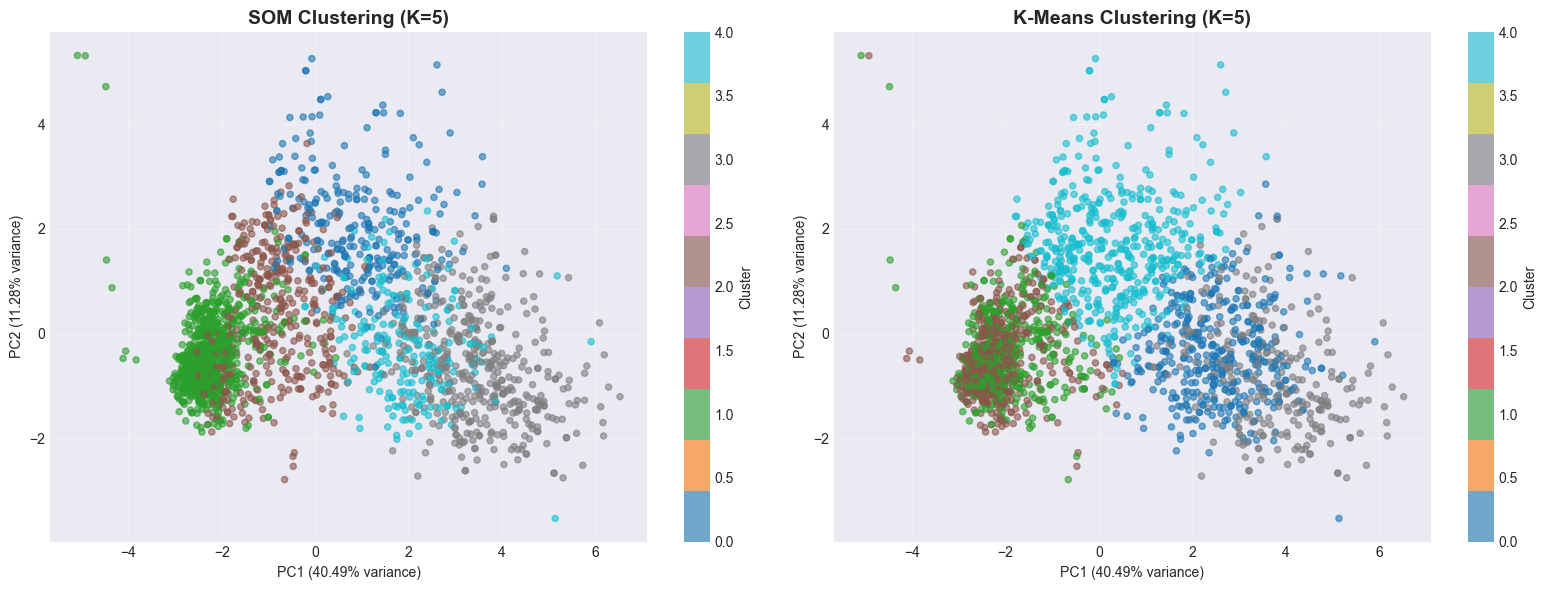

In [19]:
# Visualize cluster comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(data_scaled)

# SOM clusters
scatter1 = axes[0].scatter(data_2d[:, 0], data_2d[:, 1], 
                          c=sample_clusters, cmap='tab10', alpha=0.6, s=20)
axes[0].set_title(f'SOM Clustering (K={optimal_k})', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# K-Means clusters
scatter2 = axes[1].scatter(data_2d[:, 0], data_2d[:, 1], 
                          c=kmeans_clusters, cmap='tab10', alpha=0.6, s=20)
axes[1].set_title(f'K-Means Clustering (K={optimal_k})', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()


Clustering comparison metrics:
Adjusted Rand Index (ARI): 0.4065
Normalized Mutual Information (NMI): 0.5402

Interpretation:
- ARI = 1.0: identical clusterings
- ARI = 0.0: random agreement
- NMI = 1.0: complete mutual information
- NMI = 0.0: no mutual information


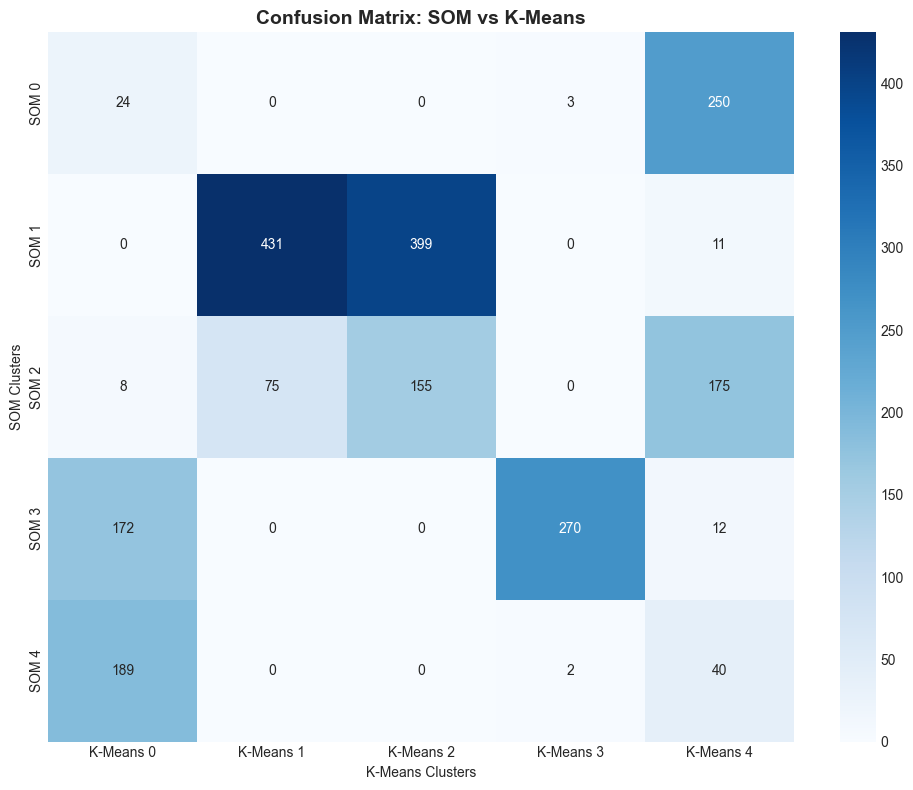

In [20]:
# Confusion matrix for cluster comparison
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compute similarity metrics
ari_score = adjusted_rand_score(sample_clusters, kmeans_clusters)
nmi_score = normalized_mutual_info_score(sample_clusters, kmeans_clusters)

print("Clustering comparison metrics:")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print("\nInterpretation:")
print("- ARI = 1.0: identical clusterings")
print("- ARI = 0.0: random agreement")
print("- NMI = 1.0: complete mutual information")
print("- NMI = 0.0: no mutual information")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(sample_clusters, kmeans_clusters)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'K-Means {i}' for i in range(optimal_k)],
            yticklabels=[f'SOM {i}' for i in range(optimal_k)])
plt.title('Confusion Matrix: SOM vs K-Means', fontsize=14, fontweight='bold')
plt.xlabel('K-Means Clusters')
plt.ylabel('SOM Clusters')
plt.tight_layout()
plt.show()


## Conclusions

### Main Results:

1. **SOM successfully trained** on customer data with 10×10 neuron grid
2. **U-Matrix visualization** revealed cluster structure in the data
3. **Customer clusters identified** with different behavioral characteristics
4. **Comparison with K-Means** showed differences and similarities in clustering approaches

### Advantages of SOM:

- **Topology preservation**: similar data points are located close to each other on the map
- **Visualization**: U-Matrix allows visual identification of clusters
- **Interpretability**: can analyze characteristics of each region on the map

### Differences from K-Means:

- SOM preserves data topology, K-Means does not
- SOM provides visual representation of data structure
- K-Means is faster, but less informative for visualization
